In [1]:
'''!pip install numpy
%pip install
%pip install scikit-learn
%pip install tensorflow --upgrade
!pip install absl-py
%pip install keras_application'''


'!pip install numpy\n%pip install\n%pip install scikit-learn\n%pip install tensorflow --upgrade\n!pip install absl-py\n%pip install keras_application'

https://www.analyticsvidhya.com/blog/2021/12/sentiment-analysis-on-tweets-with-lstm-for-beginners/

In [2]:
import numpy as np # linear algebraa
import pandas as pd #* data processing, CSV file I/O (e.g. pd.read_csv)
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

import os
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Import nltk package and download the stopwords
import nltk 
from nltk.corpus import stopwords

## Imports libs
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

from keras.preprocessing.text import Tokenizer

from keras.utils import pad_sequences
'''from keras.preprocessing.sequence import pad_sequences'''

from sklearn.preprocessing import LabelEncoder

# Import various layers needed for the architecture from keras
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

Segmentation Models: using `tf.keras` framework.


In [3]:
dataset_path = "data/training.1600000.processed.noemoticon.csv"
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding = "ISO-8859-1" , names= ["target", "ids", "date", "flag", "user", "text"])

Open file: data/training.1600000.processed.noemoticon.csv


In [4]:
df = df.drop(['ids', 'date', 'flag', 'user'], axis=1)


In [5]:
df.tail(20)

,target,text
1599980,4,@myheartandmind jo jen by nemuselo zrovna tÃ© ...
1599981,4,Another Commenting Contest! [;: Yay!!! http:/...
1599982,4,@thrillmesoon i figured out how to see my twee...
1599983,4,"@oxhot theri tomorrow, drinking coffee, talkin..."
1599984,4,You heard it here first -- We're having a girl...
1599985,4,"if ur the lead singer in a band, beware fallin..."
1599986,4,@tarayqueen too much ads on my blog.
1599987,4,@La_r_a NEVEER I think that you both will get...
1599988,4,@Roy_Everitt ha- good job. that's right - we g...
1599989,4,@Ms_Hip_Hop im glad ur doing well


In [6]:
label_to_target = {0:"Negative", 4:"Positive"}
def label_decoder(label):
     return label_to_target[label]
df.target = df.target.apply(lambda x: label_decoder(x))

<BarContainer object of 2 artists>

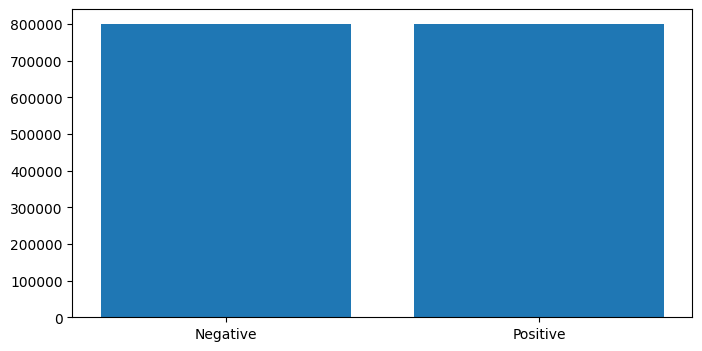

In [7]:
distribution = df.target.value_counts()
plt.figure(figsize=(8,4))
plt.bar(distribution.index, distribution.values)

In [8]:

nltk.download('stopwords')
# We filter out the english language stopwrds

stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jupiter\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')

In [10]:
import re
text_cleaning_regex = "@S+|https?:S+|http?:S|[^A-Za-z0-9]+"

In [11]:
def clean_tweets(text, stem=False):
    # Text passed to the regex equatio
    text = re.sub(text_cleaning_regex, ' ', str(text).lower()).strip()
    # Empty list created to store final tokens
    tokens = []
    for token in text.split():
    # check if the token is a stop word or not
        if token not in stop_words:
            if stem:
                # Paased to the snowball stemmer
                tokens.append(stemmer.stem(token))
            else:
                # A
                tokens.append(token)
    return " ".join(tokens)

In [12]:
df.text = df.text.apply(lambda x: clean_tweets(x))

In [13]:
# Import functions from sklearn library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Splitting the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2,random_state=16)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [14]:
tokenizer = Tokenizer()

In [15]:
tokenizer.fit_on_texts(train_data.text)
word_index = tokenizer.word_index
print(word_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 565660


In [17]:

# The tokens are converted into sequences and then passed to the pad_sequences() function
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),maxlen = 30)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),maxlen = 30)

In [18]:
labels = ['Negative', 'Positive']

encoder = LabelEncoder()
encoder.fit(train_data.target.to_list())
y_train = encoder.transform(train_data.target.to_list())
y_test = encoder.transform(test_data.target.to_list())
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [19]:
'''!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip'''

'!wget http://nlp.stanford.edu/data/glove.6B.zip\n!unzip glove.6B.zip'

In [20]:
embeddings_index = {}
# opening the downloaded glove embeddings file
f = open('data/glove.6B.300d.txt',encoding="utf8")
for line in f:
    # For each line file, the words are split and stored in a list
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [21]:
# creating an matrix with zeroes of shape vocab x embedding dimension
embedding_matrix = np.zeros((vocab_size, 300))
# Iterate through word, index in the dictionary
for word, i in word_index.items():
    # extract the corresponding vector for the vocab indice of same word
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Storing it in a matrix
        embedding_matrix[i] = embedding_vector

In [22]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,300,weights=[embedding_matrix],
                                          input_length=30,trainable=False)

In [23]:
# The Input layer 
sequence_input = Input(shape=(30,), dtype='int32')
# Inputs passed to the embedding layer
embedding_sequences = embedding_layer(sequence_input)
# dropout and conv layer 
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
# Passed on to the LSTM layer
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
# Passed on to activation layer to get final output
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [24]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,min_lr = 0.01, monitor = 'val_loss',verbose = 1)

In [25]:
training = model.fit(x_train, y_train, batch_size=1024, epochs=10,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 675s 537ms/step - loss: 0.5198 - accuracy: 0.7401 - val_loss: 0.4871 - val_accuracy: 0.7635 - lr: 0.0100
Epoch 2/10
1250/1250 [==============================] - 733s 586ms/step - loss: 0.4932 - accuracy: 0.7591 - val_loss: 0.4803 - val_accuracy: 0.7671 - lr: 0.0100
Epoch 3/10
1250/1250 [==============================] - 760s 608ms/step - loss: 0.4882 - accuracy: 0.7628 - val_loss: 0.4778 - val_accuracy: 0.7692 - lr: 0.0100
Epoch 4/10
1250/1250 [==============================] - 782s 626ms/step - loss: 0.4850 - accuracy: 0.7646 - val_loss: 0.4805 - val_accuracy: 0.7693 - lr: 0.0100
Epoch 5/10
1250/1250 [==============================] - 791s 633ms/step - loss: 0.4838 - accuracy: 0.7659 - val_loss: 0.4759 - val_accuracy: 0.7702 - lr: 0.0100
Epoch 6/10
1250/1250 [==============================] - 794s 636ms/step - loss: 0.4828 - accuracy: 0.7661 - val_loss: 0.4754 - val_accuracy: 0.7702 - lr: 0.0100
Epoch 7/10
1250/1250 [============

In [26]:
def predict_tweet_sentiment(score):
    return "Positive" if score>0.5 else "Negative"

def y_pred(score):
    return 1 if score>0.5 else 0
scores = model.predict(x_test, verbose=1, batch_size=10000)
model_predictions = [predict_tweet_sentiment(score) for score in scores]
y_pred = [y_pred(score) for score in scores]

32/32 [==============================] - 24s 725ms/step


In [27]:
from sklearn.metrics import classification_report
print(classification_report(list(test_data.target), model_predictions))

              precision    recall  f1-score   support

    Negative       0.78      0.75      0.77    159809
    Positive       0.76      0.79      0.78    160191

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



In [28]:
import pandas as pd

from sklearn.metrics import recall_score
recall=recall_score(y_test, y_pred)
from sklearn.metrics import precision_score
precision=precision_score(y_test, y_pred)
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test, y_pred)

df = pd.DataFrame({'Nom du modèle': ['Modèle Couche LSTM'], 'Recall': [recall], 'Precision': [precision], 'Accuracy': [accuracy]})

df

#export de la donnée en csv 
df.to_csv('models_results/model_keras_lstm_results.csv')

In [29]:
df

,Nom du modèle,Recall,Precision,Accuracy
0,Modèle Couche LSTM,0.794096,0.759173,0.770822


In [31]:
import pickle
#save models
pickle.dump(model, open('data/model_keras_LSTM.pkl', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\bidirectional
......vars
...layers\bidirectional\backward_layer
......vars
...layers\bidirectional\backward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional\forward_layer
......vars
...layers\bidirectional\forward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional\layer
......vars
...layers\bidirectional\layer\cell
......vars
...layers\conv1d
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dropout
......vars
...layers\embedding
......vars
.........0
...layers\input_layer
......vars
...layers\spatial_dropout1d
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12

In [32]:
from tensorflow import keras

with open('data/model_keras_LSTM.pkl', 'rb') as link:
    ml = pickle.load(link)

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-27 12:55:52         5196
metadata.json                                  2023-03-27 12:55:52           64
variables.h5                                   2023-03-27 12:55:54    684741912
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\bidirectional
......vars
...layers\bidirectional\backward_layer
......vars
...layers\bidirectional\backward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional\forward_layer
......vars
...layers\bidirectional\forward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional\layer
......vars
...layers\bidirectional\layer\cell
......vars
...layers\conv1d
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0

In [33]:
ml.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           169698000 
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048 

In [61]:
def predict(data, text_col, lemm, maxlen):
    try:
        # nettoyage
        data.text = data.text.apply(lambda x: clean_tweets(x))
        
        
        X = pad_sequences(tokenizer.texts_to_sequences(data.text),maxlen = 30)
        
        scores = model.predict(X, verbose=1, batch_size=10000)
        model_predictions = [predict_tweet_sentiment(score) for score in scores]

        return model_predictions

    except Exception as e:
        error = str(e)

        return error

In [62]:
test = {'text': ["I hate the place", "The place is beautiful", "love", "I hate the place","I have loved the place"]}
test1 = pd.DataFrame(data=test)
test1

,text
0,I hate the place
1,The place is beautiful
2,love
3,I hate the place
4,I have loved the place


In [63]:
result = predict(test1, 'text', False, 36)
result

1/1 [==============================] - 0s 378ms/step


['Negative', 'Positive', 'Positive', 'Negative', 'Positive']

In [ ]:
print(tf.__version__)

In [ ]:
'''!pip install numpy --upgrade'''

In [ ]:
'''!pip install --upgrade pip
!pip install --upgrade tensorflow'''

In [ ]:
'''!pip install tensorflow'''